## Relevant libraries and methods

In [410]:
import os
import glob

# Data handling and manipulation library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [411]:
pharDf = pd.read_csv('data_processed\sales_insights_pharmacy_cleaned.csv', delimiter=',')
hospDf = pd.read_csv('data_processed\sales_insights_hospital_cleaned.csv', delimiter=',')

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Josef\AppData\Local\Temp\ipykernel_23368\2386274991.py:1: SyntaxWarning: invalid escape sequence '\s'
  pharDf = pd.read_csv('data_processed\sales_insights_pharmacy_cleaned.csv', delimiter=',')
C:\Users\Josef\AppData\Local\Temp\ipykernel_23368\2386274991.py:2: SyntaxWarning: invalid escape sequence '\s'
  hospDf = pd.read_csv('data_processed\sales_insights_hospital_cleaned.csv', delimiter=',')


In [412]:
print(len(pharDf))
print(len(hospDf))
print(pharDf.columns)
print(hospDf.columns)

7282
4724
Index(['Account Description', 'Size', 'Size Numeric', 'Strength (mg)',
       'WHO ATC 5 Code', 'Volume', 'Value', 'Year Month (after 2000)',
       'Year (after 2000)', 'Month', 'Region_Færøerne', 'Region_Hovedstaden',
       'Region_Midtjylland', 'Region_Nordjylland', 'Region_Sjælland',
       'Region_Syddanmark', 'Product_Cimzia', 'Product_Inflectra',
       'Product_Remicade', 'Product_Remsima', 'Product_Stelara',
       'Product_Zessly'],
      dtype='object')
Index(['Account Description', 'Size', 'Size Numeric', 'Strength (mg)',
       'WHO ATC 5 Code', 'Volume', 'Value', 'Year Month (after 2000)',
       'Year (after 2000)', 'Month', 'Region_Hovedstaden',
       'Region_Midtjylland', 'Region_Nordjylland', 'Region_Sjælland',
       'Region_Syddanmark', 'Product_Cimzia', 'Product_Inflectra',
       'Product_Remicade', 'Product_Remsima', 'Product_Stelara',
       'Product_Zessly'],
      dtype='object')


#### Merge datasets phar and hosp insights and remove unwanted columns + duplicates

In [413]:
# Merge the two datasets together
merged_df = pd.concat([pharDf, hospDf], ignore_index=True)

# remove the column 'Region_Færøerne'
merged_df = merged_df.drop(columns=['Region_Færøerne'])

# drop duplicates in pharmacy_df
merged_df_no_Dups = merged_df.drop_duplicates()

# convert the float to int in column 'Year Month (after 2000)'.
# merged_df_no_Dups['Year Month (after 2000)'] = merged_df_no_Dups['Year Month (after 2000)'].astype(int)

print(len(merged_df_no_Dups))

7282


#### Divide the dataset into two subdatasets: Hospital and Pharmacy

In [414]:
hospitalDf = merged_df_no_Dups[~merged_df_no_Dups['Account Description'].str.contains('Apotek', case=False)]
pharmacyDf = merged_df_no_Dups[merged_df_no_Dups['Account Description'].str.contains('Apotek', case=False)]

print(len(hospitalDf))
print(len(pharmacyDf))

1154
6128


#### Add new Account Description ID Column

In [415]:
# Convert all values in Account Description in SortedDfApo to a numbers and store in a new column 'Account Description Number'. 
# The numbers are ascending from 100 to the number of unique values in 'Account Description'
pharDfWithAccountsIds = pharmacyDf['Account Description ID'] = pd.factorize(pharmacyDf['Account Description'])[0] + 100

# Convert all values in Account Description in SortedDfNonApo to a numbers and store in a new column 'Account Description Number'. 
# The numbers are ascending from 0 to the number of unique values in 'Account Description'
hospDfWithAccountsIds = hospitalDf['Account Description ID'] = pd.factorize(hospitalDf['Account Description'])[0]

# merge the two dataframes
hospitalPharmacyDf = pd.concat([hospitalDf, pharmacyDf], ignore_index=True)

# move the new column as the first column
hospitalPharmacyDf = hospitalPharmacyDf[['Account Description ID'] + [col for col in hospitalPharmacyDf.columns if col != 'Account Description ID']]

hospitalPharmacyDf

C:\Users\Josef\AppData\Local\Temp\ipykernel_23368\3082373766.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pharDfWithAccountsIds = pharmacyDf['Account Description ID'] = pd.factorize(pharmacyDf['Account Description'])[0] + 100
C:\Users\Josef\AppData\Local\Temp\ipykernel_23368\3082373766.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospDfWithAccountsIds = hospitalDf['Account Description ID'] = pd.factorize(hospitalDf['Account Description'])[0]


,Account Description ID,Account Description,Size,Size Numeric,Strength (mg),WHO ATC 5 Code,Volume,Value,Year Month (after 2000),Year (after 2000),Month,Region_Hovedstaden,Region_Midtjylland,Region_Nordjylland,Region_Sjælland,Region_Syddanmark,Product_Cimzia,Product_Inflectra,Product_Remicade,Product_Remsima,Product_Stelara,Product_Zessly
0,0,3061 Aalborg ø Fyrkilden,1 eng. spr. a 1 ml,1.0,90.0,L04AC05,2.0,51475.62,1508.0,15.0,8.0,False,False,True,False,False,False,False,False,False,True,False
1,0,3061 Aalborg ø Fyrkilden,1 eng. spr. a 1 ml,1.0,90.0,L04AC05,2.0,51475.62,1510.0,15.0,10.0,False,False,True,False,False,False,False,False,False,True,False
2,0,3061 Aalborg ø Fyrkilden,1 stk. (0.5 ml),1.0,45.0,L04AC05,1.0,25737.81,1511.0,15.0,11.0,False,False,True,False,False,False,False,False,False,True,False
3,0,3061 Aalborg ø Fyrkilden,1 eng. spr. a 1 ml,1.0,90.0,L04AC05,1.0,25737.81,1512.0,15.0,12.0,False,False,True,False,False,False,False,False,False,True,False
4,0,3061 Aalborg ø Fyrkilden,1 eng. spr. a 1 ml,1.0,90.0,L04AC05,1.0,25737.81,1602.0,16.0,2.0,False,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7277,257,4398 Viborg Sygehus. apoteket,1 htgl.,1.0,100.0,L04AB02,472.0,2028009.36,1310.0,13.0,10.0,False,True,False,False,False,False,False,True,False,False,False
7278,257,4398 Viborg Sygehus. apoteket,2 stk.,2.0,200.0,L04AB05,45.0,354665.70,1311.0,13.0,11.0,False,True,False,False,False,True,False,False,False,False,False
7279,257,4398 Viborg Sygehus. apoteket,1 htgl.,1.0,100.0,L04AB02,410.0,1761618.30,1311.0,13.0,11.0,False,True,False,False,False,False,False,True,False,False,False
7280,257,4398 Viborg Sygehus. apoteket,2 stk.,2.0,200.0,L04AB05,52.0,409835.92,1312.0,13.0,12.0,False,True,False,False,False,True,False,False,False,False,False


#### Sort hospital and pharmacy datasets into values between 2010 and 2019 and only for Stelara

In [416]:
hospitalDfYearSorted = hospDfWithAccountsIds[(hospDfWithAccountsIds['Year Month (after 2000)'] >= 1001) & (hospDfWithAccountsIds['Year Month (after 2000)'] <= 1912)]
PharmacyDfYearSorted = pharDfWithAccountsIds[(pharDfWithAccountsIds['Year Month (after 2000)'] >= 1001) & (pharDfWithAccountsIds['Year Month (after 2000)'] <= 1912)]
mergedHospitalPharmacyDfYearSorted = pd.concat([hospitalDfYearSorted, PharmacyDfYearSorted], ignore_index=True)

hospitalDfYearAndStelaraSorted = hospitalDfYearSorted[hospitalDfYearSorted['Product_Stelara'] == True]
PharmacyDfYearAndStelaraSorted = PharmacyDfYearSorted[PharmacyDfYearSorted['Product_Stelara'] == True]
mergedHospitalPharmacyDfYearAndStelaraSorted = pd.concat([hospitalDfYearAndStelaraSorted, PharmacyDfYearAndStelaraSorted], ignore_index=True)

print('Hospital total sales btw 2010 and 2019: ', sum(hospitalDfYearAndStelaraSorted['Volume']))
print('Pharmacy total sales btw 2010 and 2019: ', sum(PharmacyDfYearAndStelaraSorted['Volume']))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

#### Define a dataset with data only from Central Apoteket (main pharmacy next to central station)

In [417]:
centralPharmacy = PharmacyDfYearAndStelaraSorted[PharmacyDfYearAndStelaraSorted['Account Description'].str.contains('CentralApoteket', case=False)]

NameError: name 'PharmacyDfYearAndStelaraSorted' is not defined

#### Draw stacked column chart of total sales of Stelara in hospitals and pharmacies btw 2010 and 2019

C:\Users\Josef\AppData\Local\Temp\ipykernel_23368\1950800994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospitalDfYearSorted['Type'] = 'Hospitals'
C:\Users\Josef\AppData\Local\Temp\ipykernel_23368\1950800994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PharmacyDfYearSorted['Type'] = 'Pharmacies'


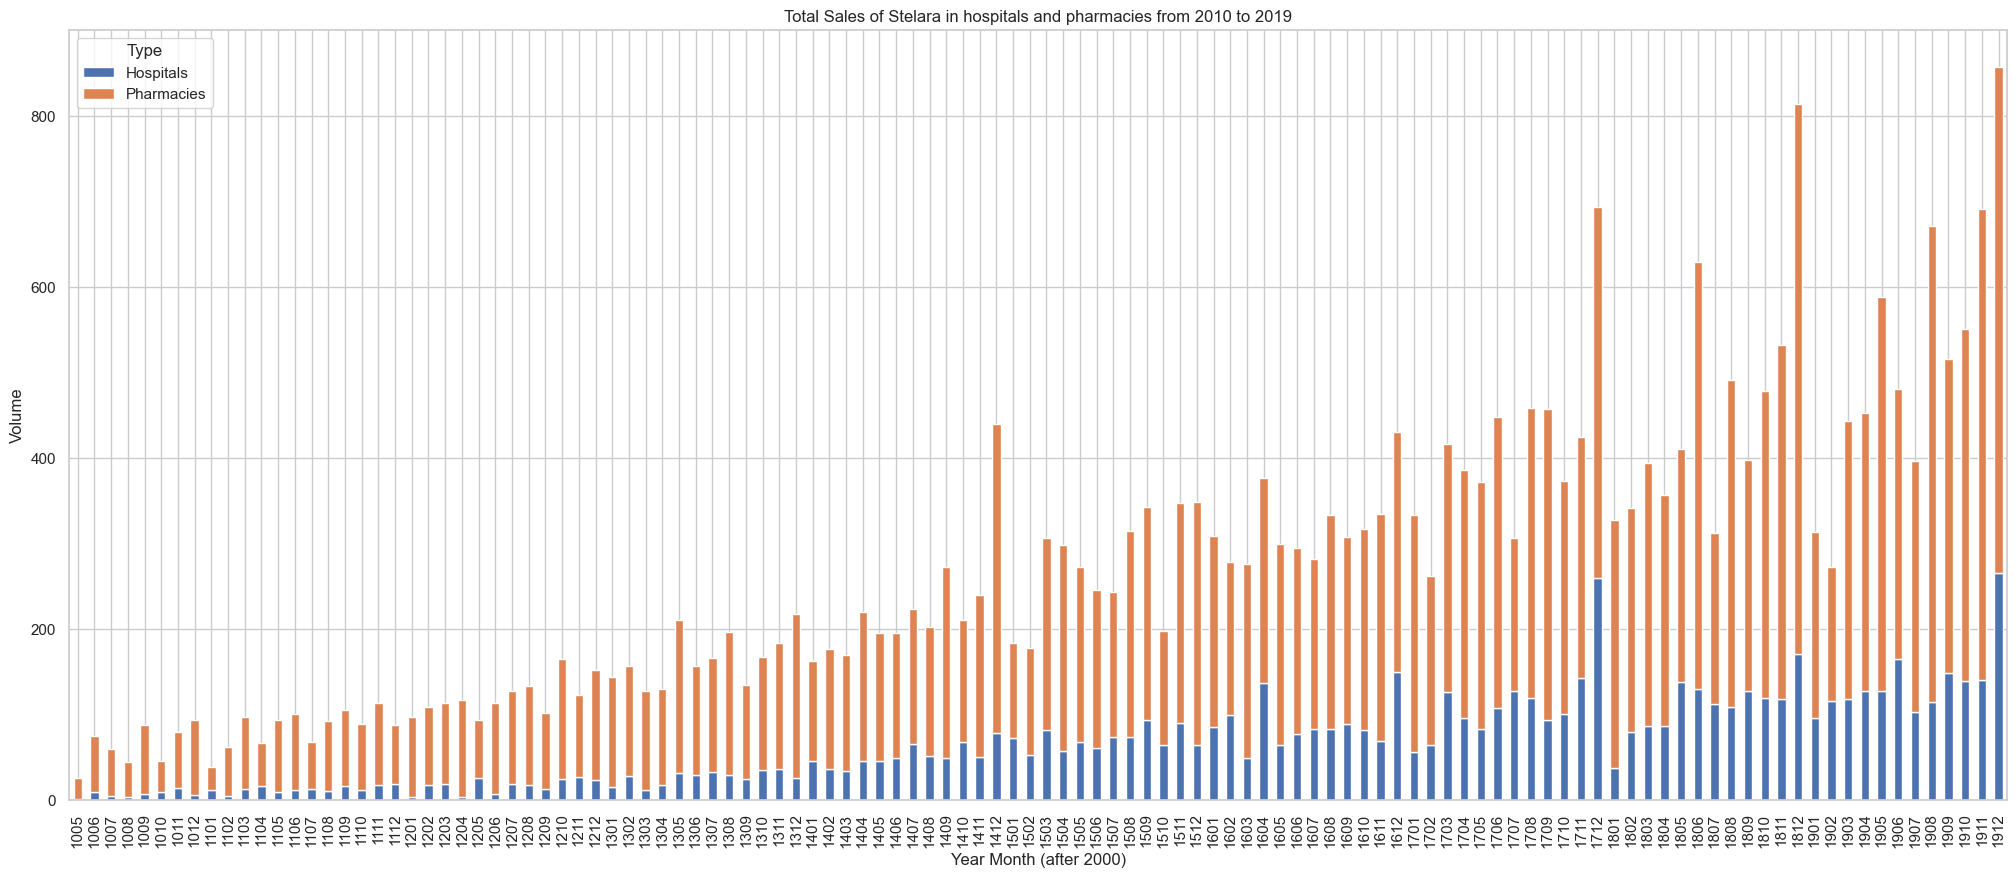

In [397]:
hospitalDfYearAndStelaraSorted['Type'] = 'Hospitals'
PharmacyDfYearAndStelaraSorted['Type'] = 'Pharmacies'
mergedHospitalPharmacyDfYearAndStelaraSortedWithTypes = pd.concat([hospitalDfYearAndStelaraSorted, PharmacyDfYearSorted], ignore_index=True)

# Pivot the data
pivot_df = mergedHospitalPharmacyDfYearAndStelaraSortedWithTypes.pivot_table(index='Year Month (after 2000)', columns='Type', values='Volume', aggfunc='sum').fillna(0)

# Plot the stacked column chart
pivot_df.plot(kind='bar', stacked=True, figsize=(25, 10))
plt.xticks(rotation=90)
plt.title('Total Sales of Stelara in hospitals and pharmacies from 2010 to 2019')
plt.ylabel('Volume')
plt.xlabel('Year Month (after 2000)')
plt.legend(title='Type')
plt.show()

<Axes: xlabel='Year Month (after 2000)', ylabel='Volume'>

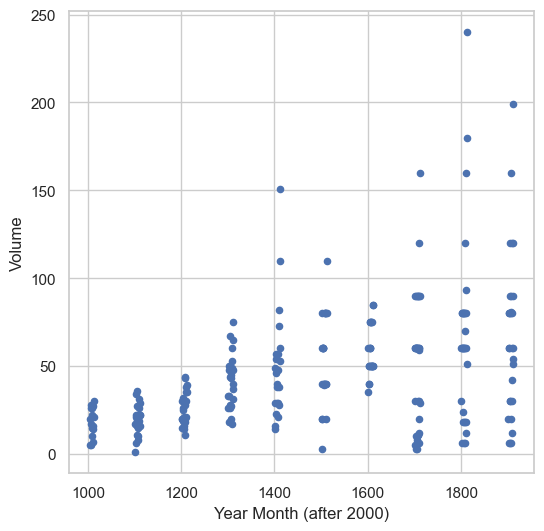

In [398]:
centralPharmacy.plot(x='Year Month (after 2000)', y='Volume', kind='scatter')

#### Draw scatter, line, bubble, or combo plot to show relationship between sold stelara over time between 2010 and 2019 in central pharmacy

##### TODO: Fix x-axis to show all months

     Year Month (after 2000)  Volume
0                       1005    12.0
1                       1006    22.0
2                       1007    16.0
3                       1008    12.0
4                       1009    24.0
..                       ...     ...
110                     1908    90.0
111                     1909    51.0
112                     1910    64.0
113                     1911    78.0
114                     1912   113.0

[115 rows x 2 columns]


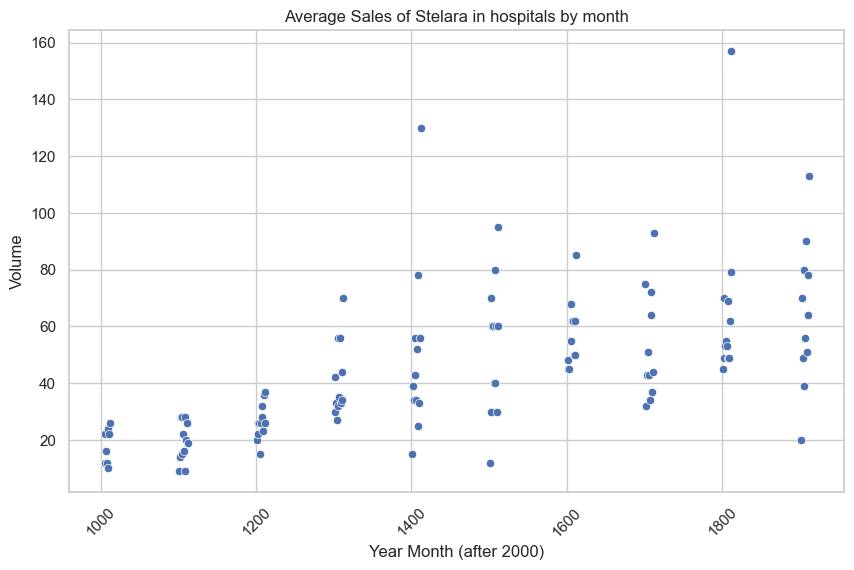

In [401]:
# Group the data by 'Year Month (after 2000)' and calculate the median of 'Value'
meanValaues = centralPharmacy.groupby('Year Month (after 2000)')['Volume'].mean().round().reset_index()

# convert 'Year Month (after 2000)' and median_values to int
print(meanValaues)

# Plot the median values in a line plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year Month (after 2000)', y='Volume', data=meanValaues)
plt.xticks(rotation=45)
plt.title('Average Sales of Stelara in hospitals by month')
plt.show()

#### Show correlation between Volume and other feeatures

20


<Axes: >

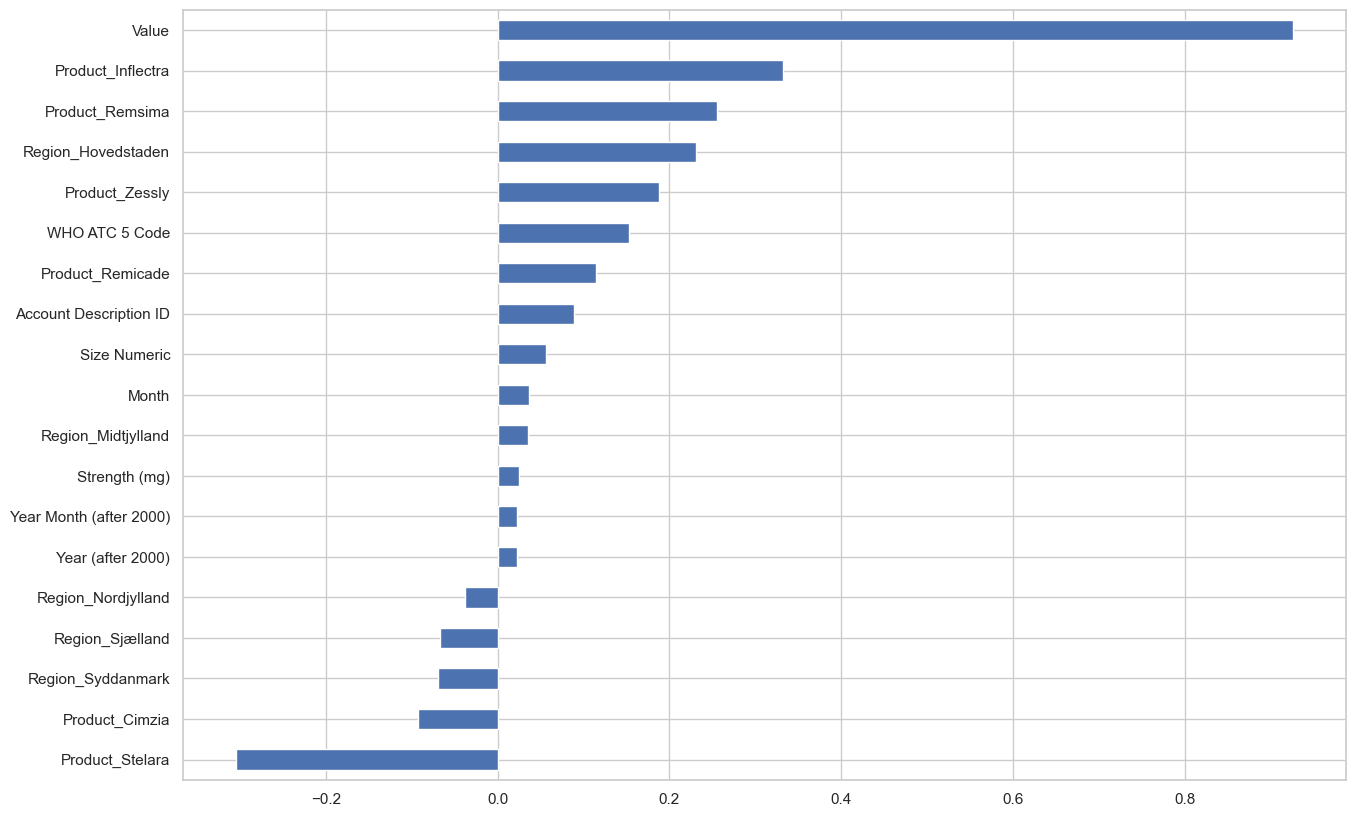

In [388]:
m = hospitalPharmacyDf.drop('Account Description', axis=1)
m2 = m.drop('Size', axis=1)

atcs = m2['WHO ATC 5 Code'].unique()

# Convert each unique value in 'WHO ATC 5 Code' to an int between 0 and 2
m2['WHO ATC 5 Code'] = m2['WHO ATC 5 Code'].apply(lambda x: np.where(atcs == x)[0][0])

# Also convert all true false values to 1 and 0 in these columns: Region_Hovedstaden	Region_Midtjylland	Region_Nordjylland	Region_Sjælland	Region_Syddanmark	Product_Cimzia	Product_Inflectra	Product_Remicade	Product_Remsima	Product_Stelara	Product_Zessly
m2['Region_Hovedstaden'] = m2['Region_Hovedstaden'].astype(int)
m2['Region_Midtjylland'] = m2['Region_Midtjylland'].astype(int)
m2['Region_Nordjylland'] = m2['Region_Nordjylland'].astype(int)
m2['Region_Sjælland'] = m2['Region_Sjælland'].astype(int)
m2['Region_Syddanmark'] = m2['Region_Syddanmark'].astype(int)
m2['Product_Cimzia'] = m2['Product_Cimzia'].astype(int)
m2['Product_Inflectra'] = m2['Product_Inflectra'].astype(int)
m2['Product_Remicade'] = m2['Product_Remicade'].astype(int)
m2['Product_Remsima'] = m2['Product_Remsima'].astype(int)
m2['Product_Stelara'] = m2['Product_Stelara'].astype(int)
m2['Product_Zessly'] = m2['Product_Zessly'].astype(int)

m2

print(len(m2.columns))

m2.drop('Volume', axis=1).corrwith(m2.Volume).sort_values().plot(kind='barh', figsize=(15, 10))